# Install libraries *(optional)*

In [1]:
pip install "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 5.3 MB/s 
     |████████████████████████████████| 462 kB 80.9 MB/s 


In [2]:
pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 90 kB 10.3 MB/s 
     |████████████████████████████████| 1.1 MB 67.8 MB/s 
     |████████████████████████████████| 352 kB 69.4 MB/s 
     |████████████████████████████████| 237 kB 80.4 MB/s 
     |████████████████████████████████| 1.2 MB 35.9 MB/s 
     |████████████████████████████████| 47.8 MB 1.1 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 99 kB 9.4 MB/s 
     |████████████████████████████████| 596 kB 64.0 MB/s 


In [3]:
pip install fasttext

     |████████████████████████████████| 68 kB 3.3 MB/s 
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3148264 sha256=ee54051cc1e1f3d5c6166c3f0538c044778f15545d53f1975911b5d783435b8c
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [4]:
# import fasttext.util ## Run only once
# fasttext.util.download_model('en', if_exists='ignore')

# Load Libraries

In [5]:
import collections
import pathlib
import os
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import re
import shutil
import string

import fasttext # word embeddings

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras.layers import TextVectorization

import tensorflow_text as tf_text
from official.nlp import optimization  # to create AdamW optimizer

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa # mathew's correlation coef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

tf.get_logger().setLevel('ERROR')

# Load Dataset

In [6]:
## South Park dataset from http://southpark.wikia.com/wiki/Portal:Scripts
## Dataset compiled by BobAdamsEE @ https://github.com/BobAdamsEE/SouthParkData
raw_ds = pd.read_csv(
    '/content/drive/MyDrive/CS521/dataset/south_park_raw_ds_t3.csv'
)

In [7]:
## Remove null data points
raw_ds = raw_ds.loc[~raw_ds.dialogue.isnull()]

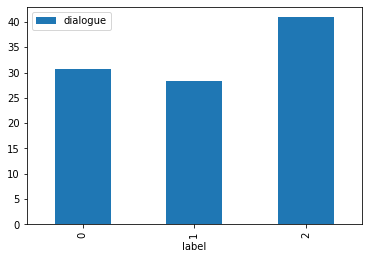

In [8]:
## Distribution of target classes in the raw dataset
raw_ds.groupby('label').count().div(raw_ds.shape[0]).mul(100).round(1).plot(kind='bar')

In [9]:
## Split raw data into train(70%), test(15%) & validation(15%)

train_x, test_x, train_y, test_y = train_test_split(
    raw_ds.dialogue, raw_ds.label, 
    test_size=0.3,
    random_state=1,
    stratify=raw_ds.label
    )

validation_x, test_x, validation_y, test_y = train_test_split(
    test_x, test_y, 
    test_size=0.5,
    random_state=1,
    stratify=test_y
    )

# Custom optimizer

In [10]:
## reaches the optimum learning rate without needing to actually specify one
epochs = 5
steps_per_epoch = 3
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
init_lr = 3e-5

optimizer = optimization.create_optimizer(
              init_lr=init_lr,
              num_train_steps=num_train_steps,
              num_warmup_steps=num_warmup_steps,
              optimizer_type='adamw'
              )

In [13]:
labels=['Stan','Kyle','Cartman']

# BERTs

#### Dictionary for links to pre trained BERT models in TensorFlow hub

In [12]:
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/3', #https://tfhub.dev/google/albert_base/2
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

#### Word embedding model 

In [13]:
## Replace the bert_model_name variable with any of the below 4.
#'bert_en_cased_L-12_H-768_A-12'
#'albert_en_base'
#'small_bert/bert_en_uncased_L-2_H-128_A-2'
#'small_bert/bert_en_uncased_L-4_H-512_A-8' 
bert_model_name = 'bert_en_cased_L-12_H-768_A-12'
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3


In [14]:
def get_bert_word_embeddings(
    text_col, 
    tfhub_handle_preprocess, 
    tfhub_handle_encoder, 
    fine_tune_flag
    ):
  
  """
  Takes in 
    the text column in the dataset, 
    the encoder & its preprocess handlers,
    the fine_tune_flag to enable or disable fine tuning the BERTs

  Returns the input layer & the word embeddings layer

  """
  
  text_input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string, name=text_col)
  
  preprocessing_layer = hub.KerasLayer(
      tfhub_handle_preprocess, 
      name='preprocessing'
      )
  encoder_inputs = preprocessing_layer(text_input_layer)
  encoder = hub.KerasLayer(
      tfhub_handle_encoder, 
      trainable=fine_tune_flag, 
      name='BERT_encoder'
      )
  outputs = encoder(encoder_inputs)
  
  return text_input_layer, outputs

  
text_input_layer, bert_word_embeddings = get_bert_word_embeddings(
  text_col='dialogue', 
  tfhub_handle_preprocess=tfhub_handle_preprocess, 
  tfhub_handle_encoder=tfhub_handle_encoder,
  fine_tune_flag=False
  )

#### Simple DNN Model

In [16]:
def simple_dnn_classifier_model(
    num_labels, 
    text_input_layer,
    outputs
    ):
  
  """
  Takes in 
    the number of output classes, 
    the text input layer,
    the word embeddings BERTs
  Constructs the layers
  Returns the keras model

  """
    
  net = outputs['pooled_output'] 
  net = tf.keras.layers.Dense(256, activation="selu", name="dense_layer1")(net)
  net = tf.keras.layers.Dense(256, activation="selu", name='dense_layer2')(net)
  net = tf.keras.layers.Dropout(0.2, name='dropout_layer')(net)
  
  out = tf.keras.layers.Dense(num_labels, activation="softmax", name='classifier')(net)
  
  return tf.keras.Model(text_input_layer, out)


cls_model = simple_dnn_classifier_model(
    num_labels=3,
    text_input_layer=text_input_layer, 
    outputs=bert_word_embeddings
    ) 
cls_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dialogue (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['dialogue[0][0]']               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [ ]:
# Compile & fit the model to the training data; val data is passed here
# The EarlyStopping callback is also passed. This stops the training when
# the improvement is less than 5 & restores the best weights at the end

cls_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )


print(f'Training model with {tfhub_handle_encoder}')
early_stopping_cb = tf.keras.callbacks.EarlyStopping(min_delta=5,restore_best_weights=True)
history = cls_model.fit(
    train_x, train_y, 
    validation_data=(validation_x, validation_y),
    epochs=epochs, batch_size=32
    ,callbacks=[early_stopping_cb]
    )

cls_model.save('/content/drive/MyDrive/CS521/models/simple_dnn_model_bert_cased')

##### Model evaluation

Matthews Correlation Coefficient: 0.0


F1 scores: [{'Stan': 0.47}, {'Kyle': 0.0}, {'Cartman': 0.0}]




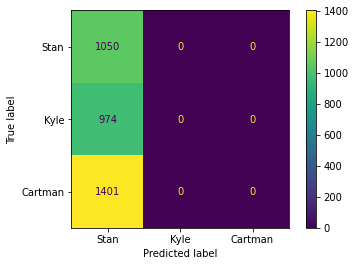

In [18]:
# Load the model when necessary
# predict the classes for test data
# calculate the Matthew's Corr Coeff & F1 scores of each class
# MCC score of 0 indicates the predictions are no better than random guesses
# plot the confusion matrix

cls_model = tf.keras.models.load_model(
    '/content/drive/MyDrive/CS521/models/simple_dnn_model',
    compile=False
    )
pred_y = cls_model.predict(test_x)

mcc = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=3)

mcc.update_state(test_y.values.reshape(-1,1), np.argmax(pred_y, axis=1).reshape(-1,1))
result = mcc.result()
print(f"Matthews Correlation Coefficient: {result.numpy()}\n\n")

f1_score_ = f1_score(
    test_y, np.argmax(pred_y, axis=1), 
    average=None
    )
labels=['Stan','Kyle','Cartman']
print(f"F1 scores: {[{label:round(score,2)} for label, score in zip(labels, f1_score_)]}\n\n")

cm = confusion_matrix(
      test_y.values.reshape(-1,1), 
      np.argmax(pred_y, axis=1).reshape(-1,1)
      )
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Stan','Kyle','Cartman'])
disp.plot();

#### CNN based model

In [19]:
## Replace the bert_model_name variable with any of the below 4.
#'bert_en_cased_L-12_H-768_A-12'
#'albert_en_base'
#'small_bert/bert_en_uncased_L-2_H-128_A-2'
#'small_bert/bert_en_uncased_L-4_H-512_A-8' 
bert_model_name = 'albert_en_base'
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

text_input_layer, bert_word_embeddings = get_bert_word_embeddings(
  text_col='dialogue', 
  tfhub_handle_preprocess=tfhub_handle_preprocess, 
  tfhub_handle_encoder=tfhub_handle_encoder,
  fine_tune_flag=False
  )

BERT model selected           : https://tfhub.dev/tensorflow/albert_en_base/3
Preprocess model auto-selected: https://tfhub.dev/tensorflow/albert_en_preprocess/3


In [20]:
def cnn_classifier_model(
    num_labels, 
    text_input_layer,
    outputs
    ):
  
  """
  Takes in 
    the number of output classes, 
    the text input layer,
    the word embeddings BERTs
  Constructs the layers
  Returns the keras model

  """
    
  # sequence_output -- represents each input token in the sentence context
  net = outputs['sequence_output'] 
  net = tf.keras.layers.Conv1D(128, 3, activation="relu", name='cnn1d')(net)
  net = tf.keras.layers.GlobalAveragePooling1D()(net)
  net = tf.keras.layers.Dense(256, activation="selu", name='dense1')(net)
  net = tf.keras.layers.Dropout(0.2, name='dropout1')(net)
  
  out = tf.keras.layers.Dense(num_labels, activation="softmax", name='classifier')(net)
  
  return tf.keras.Model(text_input_layer, out)

cls_model = cnn_classifier_model(
  num_labels=3,
  text_input_layer=text_input_layer, 
  outputs=bert_word_embeddings
  ) 
cls_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dialogue (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['dialogue[0][0]']               
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [ ]:
# Compile & fit the model to the training data; val data is passed here
# The EarlyStopping callback is also passed. This stops the training when
# the improvement is less than 5 & restores the best weights at the end

cls_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )


print(f'Training model with {tfhub_handle_encoder}')
early_stopping_cb = tf.keras.callbacks.EarlyStopping(min_delta=5,restore_best_weights=True)
history = cls_model.fit(
    train_x, train_y, 
    validation_data=(validation_x, validation_y),
    epochs=epochs, batch_size=32
    ,callbacks=[early_stopping_cb]
    )

cls_model.save('/content/drive/MyDrive/CS521/models/cnn_based_model_albert')

##### Model evaluation

Matthews Correlation Coefficient: 0.0


F1 scores: [{'Stan': 0.0}, {'Kyle': 0.21}, {'Cartman': 0.57}]




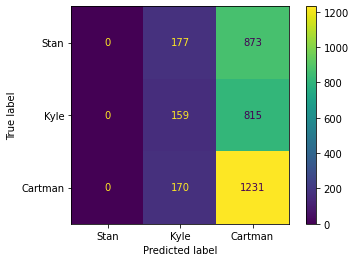

In [23]:
# Load the model when necessary
# predict the classes for test data
# calculate the Matthew's Corr Coeff & F1 scores of each class
# MCC score of 0 indicates the predictions are no better than random guesses
# plot the confusion matrix

# cls_model = tf.keras.models.load_model(
#     '/content/drive/MyDrive/CS521/models/cnn_based_model',
#     compile=False
#     )
pred_y = cls_model.predict(test_x)

mcc = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=3)

mcc.update_state(test_y.values.reshape(-1,1), np.argmax(pred_y, axis=1).reshape(-1,1))
result = mcc.result()
print(f"Matthews Correlation Coefficient: {result.numpy()}\n\n")

f1_score_ = f1_score(
    test_y, np.argmax(pred_y, axis=1), 
    average=None
    )
labels=['Stan','Kyle','Cartman']
print(f"F1 scores: {[{label:round(score,2)} for label, score in zip(labels, f1_score_)]}\n\n")

cm = confusion_matrix(
      test_y.values.reshape(-1,1), 
      np.argmax(pred_y, axis=1).reshape(-1,1)
      )
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Stan','Kyle','Cartman'])
disp.plot();

#### RNN based

In [ ]:
## Replace the bert_model_name variable with any of the below 4.
#'bert_en_cased_L-12_H-768_A-12'
#'albert_en_base'
#'small_bert/bert_en_uncased_L-2_H-128_A-2'
#'small_bert/bert_en_uncased_L-4_H-512_A-8' 
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

text_input_layer, bert_word_embeddings = get_bert_word_embeddings(
  text_col='dialogue', 
  tfhub_handle_preprocess=tfhub_handle_preprocess, 
  tfhub_handle_encoder=tfhub_handle_encoder,
  fine_tune_flag=False
  )

In [ ]:
def rnn_classifier_model(
    num_labels, 
    text_input_layer,
    outputs
    ):
  
  """
  Takes in 
    the number of output classes, 
    the text input layer,
    the word embeddings BERTs
  Constructs the layers
  Returns the keras model

  """
    
  # sequence_output -- represents each input token in the sentence context
  # pooled_output
  net = outputs['sequence_output'] 
  net = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256))(net)
  net = tf.keras.layers.Dense(256, activation="selu", name='dense1')(net)
  net = tf.keras.layers.Dropout(0.2, name='dropout1')(net)
  
  out = tf.keras.layers.Dense(num_labels, activation="softmax", name='classifier')(net)
  
  return tf.keras.Model(text_input_layer, out)

cls_model = rnn_classifier_model(
  num_labels=3,
  text_input_layer=text_input_layer, 
  outputs=bert_word_embeddings
  ) 
cls_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dialogue (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['dialogue[0][0]']               
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [ ]:
# Compile & fit the model to the training data; val data is passed here
# The EarlyStopping callback is also passed. This stops the training when
# the improvement is less than 5 & restores the best weights at the end

cls_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )


print(f'Training model with {tfhub_handle_encoder}')
early_stopping_cb = tf.keras.callbacks.EarlyStopping(min_delta=5,restore_best_weights=True)
history = cls_model.fit(
    train_x, train_y, 
    validation_data=(validation_x, validation_y),
    epochs=epochs, batch_size=32
    ,callbacks=[early_stopping_cb]
    )

cls_model.save('/content/drive/MyDrive/CS521/models/rnn_based_model_bert_cased')

##### Model evaluation

Matthews Correlation Coefficient: 0.0


F1 scores: [{'Stan': 0.4}, {'Kyle': 0.27}, {'Cartman': 0.05}]




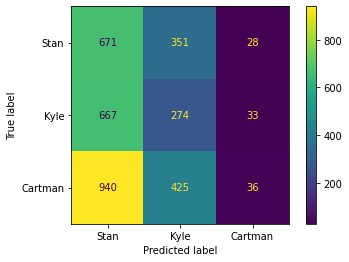

In [ ]:
# Load the model when necessary
# predict the classes for test data
# calculate the Matthew's Corr Coeff & F1 scores of each class
# MCC score of 0 indicates the predictions are no better than random guesses
# plot the confusion matrix

# cls_model = tf.keras.models.load_model(
#     '/content/drive/MyDrive/CS521/models/rnn_based_model',
#     compile=False
#     )
pred_y = cls_model.predict(test_x)

mcc = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=3)

mcc.update_state(test_y.values.reshape(-1,1), np.argmax(pred_y, axis=1).reshape(-1,1))
result = mcc.result()
print(f"Matthews Correlation Coefficient: {result.numpy()}\n\n")

f1_score_ = f1_score(
    test_y, np.argmax(pred_y, axis=1), 
    average=None
    )
labels=['Stan','Kyle','Cartman']
print(f"F1 scores: {[{label:round(score,2)} for label, score in zip(labels, f1_score_)]}\n\n")

cm = confusion_matrix(
      test_y.values.reshape(-1,1), 
      np.argmax(pred_y, axis=1).reshape(-1,1)
      )
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Stan','Kyle','Cartman'])
disp.plot();

# FastText

#### FastText Pre trained word embeddings

In [ ]:
# load the fasttext model
ft = fasttext.load_model('/content/drive/MyDrive/CS521/cc.en.300.bin')
# fasttext.util.reduce_model(ft, 100) ## For lower dimension word vecs

In [ ]:
# create the keras vectorizer & adapt it to the training data set
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=300)
vectorizer.adapt(train_x)

In [ ]:
# create the word index from the vectorizer
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
# create the embedding matrix for the input sequences
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = ft.get_word_vector(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 10804 words (0 misses)


In [ ]:
# Create the keras embedding layer
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

#### Simple DNN

In [160]:
def simple_dnn_classifier_model_ft(
    num_labels, 
    text_col,
    embedding_layer
    ):
  
  """
  Takes in 
    the number of output classes, 
    the text input layer,
    the word embeddings FastText
  Constructs the layers
  Returns the keras model

  """
    
  
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name=text_col)
  net = vectorizer(text_input)
  net = embedding_layer(net)
  net = tf.keras.layers.Flatten()(net)
  net = tf.keras.layers.Dense(512, activation="selu", name="dense_layer1")(net)
  net = tf.keras.layers.Dense(512, activation="selu", name='dense_layer2')(net)
  net = tf.keras.layers.Dropout(0.2, name='dropout_layer')(net)
  
  out = tf.keras.layers.Dense(num_labels, activation="softmax", name='classifier')(net)
  
  return tf.keras.Model(text_input, out)


cls_model = simple_dnn_classifier_model_ft(
    num_labels=3,
    text_col='dialogue', 
    embedding_layer=embedding_layer
    ) 
cls_model.summary()

Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dialogue (InputLayer)       [(None,)]                 0         
                                                                 
 text_vectorization_1 (TextV  (None, 300)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     multiple                  3241800   
                                                                 
 flatten_6 (Flatten)         (None, 90000)             0         
                                                                 
 dense_layer1 (Dense)        (None, 512)               46080512  
                                                                 
 dense_layer2 (Dense)        (None, 512)               262656    
                                                          

In [161]:
# Compile & fit the model to the training data; val data is passed here
# The EarlyStopping callback is also passed. This stops the training when
# the improvement is less than 5 & restores the best weights at the end

cls_model.compile(optimizer=optimizer,
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                         metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(min_delta=5,restore_best_weights=True)
history = cls_model.fit(
    train_x, train_y, 
    validation_data=(validation_x, validation_y),
    epochs=5, batch_size=32
    ,callbacks=[early_stopping_cb]
    )

cls_model.save('/content/drive/MyDrive/CS521/models/simple_dnn_based_model_ft')

Epoch 1/5
500/500 [==============================] - 39s 77ms/step - loss: 1.0962 - sparse_categorical_accuracy: 0.3508 - val_loss: 1.0953 - val_sparse_categorical_accuracy: 0.3621
Epoch 2/5
500/500 [==============================] - 38s 76ms/step - loss: 1.0969 - sparse_categorical_accuracy: 0.3537 - val_loss: 1.0953 - val_sparse_categorical_accuracy: 0.3621


##### Model evaluation

Matthews Correlation Coefficient: 0.0


F1 scores: [{'Stan': 0.31}, {'Kyle': 0.28}, {'Cartman': 0.42}]




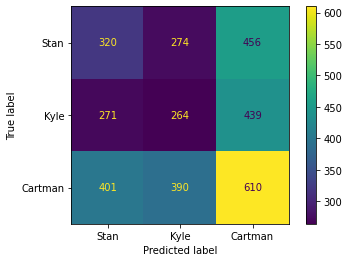

In [162]:
# Load the model when necessary
# predict the classes for test data
# calculate the Matthew's Corr Coeff & F1 scores of each class
# MCC score of 0 indicates the predictions are no better than random guesses
# plot the confusion matrix

# cls_model = tf.keras.models.load_model(
#     '/content/drive/MyDrive/CS521/models/rnn_based_model',
#     compile=False
#     )
pred_y = cls_model.predict(test_x)

mcc = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=3)

mcc.update_state(test_y.values.reshape(-1,1), np.argmax(pred_y, axis=1).reshape(-1,1))
result = mcc.result()
print(f"Matthews Correlation Coefficient: {result.numpy()}\n\n")

f1_score_ = f1_score(
    test_y, np.argmax(pred_y, axis=1), 
    average=None
    )
labels=['Stan','Kyle','Cartman']
print(f"F1 scores: {[{label:round(score,2)} for label, score in zip(labels, f1_score_)]}\n\n")

cm = confusion_matrix(
      test_y.values.reshape(-1,1), 
      np.argmax(pred_y, axis=1).reshape(-1,1)
      )
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Stan','Kyle','Cartman'])
disp.plot();

#### CNN Based

In [163]:
def cnn_classifier_model_ft(
    num_labels, 
    text_col,
    embedding_layer
    ):
  
  """
  Takes in 
    the number of output classes, 
    the text input layer,
    the word embeddings FastText
  Constructs the layers
  Returns the keras model

  """
    
  
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name=text_col)
  net = vectorizer(text_input)
  net = embedding_layer(net)
  
  net = tf.keras.layers.Conv1D(128, 3, activation="relu", name='cnn1d')(net)
  net = tf.keras.layers.GlobalAveragePooling1D()(net)
  net = tf.keras.layers.Dense(256, activation="selu", name='dense1')(net)
  net = tf.keras.layers.Dropout(0.2, name='dropout1')(net)
  
  out = tf.keras.layers.Dense(num_labels, activation="softmax", name='classifier')(net)
  
  return tf.keras.Model(text_input, out)


cls_model = cnn_classifier_model_ft(
    num_labels=3,
    text_col='dialogue', 
    embedding_layer=embedding_layer
    ) 
cls_model.summary()

Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dialogue (InputLayer)       [(None,)]                 0         
                                                                 
 text_vectorization_1 (TextV  (None, 300)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     multiple                  3241800   
                                                                 
 cnn1d (Conv1D)              (None, 298, 128)          115328    
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense1 (Dense)              (None, 256)               330

In [168]:
# Compile & fit the model to the training data; val data is passed here
# The EarlyStopping callback is also passed. This stops the training when
# the improvement is less than 5 & restores the best weights at the end

cls_model.compile(optimizer=optimizer,
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                         metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(min_delta=5,restore_best_weights=True)
history = cls_model.fit(
    train_x, train_y, 
    validation_data=(validation_x, validation_y),
    epochs=5, batch_size=32
    ,callbacks=[early_stopping_cb]
    )

cls_model.save('/content/drive/MyDrive/CS521/models/cnn_based_model_ft')

Epoch 1/5
500/500 [==============================] - 12s 23ms/step - loss: 1.0990 - sparse_categorical_accuracy: 0.3134 - val_loss: 1.0989 - val_sparse_categorical_accuracy: 0.3125
Epoch 2/5
500/500 [==============================] - 11s 22ms/step - loss: 1.0990 - sparse_categorical_accuracy: 0.3147 - val_loss: 1.0989 - val_sparse_categorical_accuracy: 0.3125


##### Model evaluation

Matthews Correlation Coefficient: 0.0


F1 scores: [{'Stan': 0.39}, {'Kyle': 0.28}, {'Cartman': 0.16}]




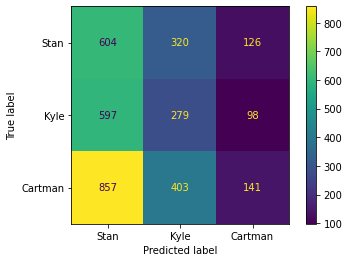

In [169]:
# Load the model when necessary
# predict the classes for test data
# calculate the Matthew's Corr Coeff & F1 scores of each class
# MCC score of 0 indicates the predictions are no better than random guesses
# plot the confusion matrix

# cls_model = tf.keras.models.load_model(
#     '/content/drive/MyDrive/CS521/models/cnn_based_model_ft',
#     compile=False
#     )
pred_y = cls_model.predict(test_x)

mcc = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=3)

mcc.update_state(test_y.values.reshape(-1,1), np.argmax(pred_y, axis=1).reshape(-1,1))
result = mcc.result()
print(f"Matthews Correlation Coefficient: {result.numpy()}\n\n")

f1_score_ = f1_score(
    test_y, np.argmax(pred_y, axis=1), 
    average=None
    )
labels=['Stan','Kyle','Cartman']
print(f"F1 scores: {[{label:round(score,2)} for label, score in zip(labels, f1_score_)]}\n\n")

cm = confusion_matrix(
      test_y.values.reshape(-1,1), 
      np.argmax(pred_y, axis=1).reshape(-1,1)
      )
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Stan','Kyle','Cartman'])
disp.plot();

#### RNN Based

In [170]:
def rnn_classifier_model_ft(
    num_labels, 
    text_col,
    embedding_layer
    ):
  
  """
  Takes in 
    the number of output classes, 
    the text input layer,
    the word embeddings FastText
  Constructs the layers
  Returns the keras model

  """
    
  
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name=text_col)
  net = vectorizer(text_input)
  net = embedding_layer(net)
  
  net = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256))(net)
  net = tf.keras.layers.Dense(256, activation="selu", name='dense1')(net)
  net = tf.keras.layers.Dropout(0.2, name='dropout1')(net)
  
  out = tf.keras.layers.Dense(num_labels, activation="softmax", name='classifier')(net)
  
  return tf.keras.Model(text_input, out)


cls_model = rnn_classifier_model_ft(
    num_labels=3,
    text_col='dialogue', 
    embedding_layer=embedding_layer
    ) 
cls_model.summary()

Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dialogue (InputLayer)       [(None,)]                 0         
                                                                 
 text_vectorization_1 (TextV  (None, 300)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     multiple                  3241800   
                                                                 
 bidirectional_7 (Bidirectio  (None, 512)              857088    
 nal)                                                            
                                                                 
 dense1 (Dense)              (None, 256)               131328    
                                                                 
 dropout1 (Dropout)          (None, 256)               0  

In [ ]:
# Compile & fit the model to the training data; val data is passed here
# The EarlyStopping callback is also passed. This stops the training when
# the improvement is less than 5 & restores the best weights at the end

cls_model.compile(optimizer=optimizer,
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                         metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
# checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_keras_model.h5")
early_stopping_cb = tf.keras.callbacks.EarlyStopping(min_delta=5,restore_best_weights=True)
history = cls_model.fit(
    train_x, train_y, 
    validation_data=(validation_x, validation_y),
    epochs=5, batch_size=32
    ,callbacks=[early_stopping_cb]
    )

cls_model.save('/content/drive/MyDrive/CS521/models/rnn_based_model_ft')

##### Model evaluation

Matthews Correlation Coefficient: 0.0


F1 scores: [{'Stan': 0.22}, {'Kyle': 0.35}, {'Cartman': 0.41}]




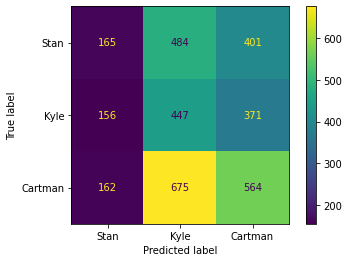

In [172]:
# Load the model when necessary
# predict the classes for test data
# calculate the Matthew's Corr Coeff & F1 scores of each class
# MCC score of 0 indicates the predictions are no better than random guesses
# plot the confusion matrix

# cls_model = tf.keras.models.load_model(
#     '/content/drive/MyDrive/CS521/models/rnn_based_model_ft',
#     compile=False
#     )
pred_y = cls_model.predict(test_x)

mcc = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=3)

mcc.update_state(test_y.values.reshape(-1,1), np.argmax(pred_y, axis=1).reshape(-1,1))
result = mcc.result()
print(f"Matthews Correlation Coefficient: {result.numpy()}\n\n")

f1_score_ = f1_score(
    test_y, np.argmax(pred_y, axis=1), 
    average=None
    )
labels=['Stan','Kyle','Cartman']
print(f"F1 scores: {[{label:round(score,2)} for label, score in zip(labels, f1_score_)]}\n\n")

cm = confusion_matrix(
      test_y.values.reshape(-1,1), 
      np.argmax(pred_y, axis=1).reshape(-1,1)
      )
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Stan','Kyle','Cartman'])
disp.plot();

# Predictions

In [43]:
def get_predictions_df(test_x, test_y, pred_y):
  return pd.DataFrame(
          np.concatenate(
              (test_x.values.reshape(-1,1), test_y.values.reshape(-1,1), pred_y),
              axis=1
              ),
          columns=['dialogue','true_label'] + [i for i in range(pred_y.shape[1])]
          )

In [ ]:
models = [d for d in listdir('/content/drive/MyDrive/CS521/models/SouthPark/')]
for model_name in models:
  cls_model = tf.keras.models.load_model(
      '/content/drive/MyDrive/CS521/models/SouthPark/'+model_name,
      compile=False
      )
  pred_y = cls_model.predict(test_x)
  get_predictions_df(test_x, test_y, pred_y).to_csv(f'/content/drive/MyDrive/CS521/predictions/SouthPark/{model_name}.csv', index=0)

In [90]:
mypath = '/content/drive/MyDrive/CS521/predictions/SouthPark/'
prediction_files = [f for f in listdir(mypath) if isfile(join(mypath,f))]
output = []

for f in prediction_files:
  pred_df = pd.read_csv(f'{mypath}{f}')
  mean_pred_prob = pred_df.iloc[:,2:].apply(np.mean, axis=0).values.tolist()
  std_pred_prob = pred_df.iloc[:,2:].apply(np.std, axis=0).values.tolist()
  model_name = [f.split('.')[0]]

  output.append(model_name + [(round(m,3),round(s,3)) for m,s in zip(mean_pred_prob, std_pred_prob)])

model_pred_stat_df = pd.DataFrame(
    data=output,
    columns=['model']+labels
)

model_pred_stat_df.to_csv(f'{mypath}model_prediction_statistics.csv', index=0)